# __4.0 Modeling and Evaluation__

## __4.1 Import Libraries__

In [10]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd



## __4.2 Modeling__

Below, I will initialize a `Modeling` class to preprocess data, train machine learning models, save predictions, and save trained models. It loads training and testing datasets, preprocesses the data, trains models including Decision Trees, KNN, Random Forest, XGBoost, and a Voting Classifier, and then saves the predictions and trained models to files. If the 'status_group' column is missing in the training dataset, it raises a `KeyError`.

In [11]:
class Modeling:
    def __init__(self, train_path, test_path, use_smote=False):
        self.train_path = train_path
        self.test_path = test_path
        self.use_smote = use_smote
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path)
        self.models = {}
        self.best_model = None
        self.le = LabelEncoder()
        self.preprocessor = None

        if 'status_group' not in self.train_data.columns:
            raise KeyError("'status_group' column is missing from the training dataset")
# preprocess data function
    def preprocess_data(self):
        cat_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype == 'object' and 
                    self.train_data[col].nunique() < 25 and 
                    col != 'status_group']

        num_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype in ['int64', 'float64'] and 
                    col not in ['id', 'status_group']]

        self.train_data['status_group'] = self.le.fit_transform(self.train_data['status_group'])
# encode data
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
            ])

        X_train = self.train_data[num_cols + cat_cols]
        y_train = self.train_data['status_group']

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)
# use smote to balance the data
        if self.use_smote:
            smote = SMOTE(random_state=42)
            X_train_preprocessed, y_train = smote.fit_resample(X_train_preprocessed, y_train)

        self.preprocessor = preprocessor

        return X_train_preprocessed, X_val_preprocessed, y_train, y_val, cat_cols, num_cols, X_train
# transform categorical data to numerical format 
    def preprocess_test_data(self):
        cat_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype == 'object' and 
                    self.train_data[col].nunique() < 25 and 
                    col != 'status_group']

        num_cols = [col for col in self.train_data.columns 
                    if self.train_data[col].dtype in ['int64', 'float64'] and 
                    col not in ['id', 'status_group']]

        X_test = self.test_data[num_cols + cat_cols]

        X_test_preprocessed = self.preprocessor.transform(X_test)

        return X_test_preprocessed

    def train_models(self):
        X_train, X_val, y_train, y_val, cat_cols, num_cols, X = self.preprocess_data()
# train decision tree models
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=5)
        dt_model.fit(X_train, y_train)
        self.models['Simple Decision Tree'] = dt_model

        param_grid = {
            'max_depth': [3, 5, 7], 
            'min_samples_split': [2, 5, 10],
            'ccp_alpha': [0.0, 0.01, 0.1]
        }
        tuned_dt_model = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
        tuned_dt_model.fit(X_train, y_train)
        self.models['Tuned Decision Tree'] = tuned_dt_model.best_estimator_
# train knn model
        knn_model = KNeighborsClassifier()
        knn_model.fit(X_train, y_train)
        self.models['KNN'] = knn_model
# train random forest model
        rf_model = RandomForestClassifier(random_state=42, max_depth=10)
        rf_model.fit(X_train, y_train)
        self.models['Random Forest'] = rf_model
# train xgboost model
        xgb_model = XGBClassifier(random_state=42, n_jobs=-1, reg_lambda=1)
        xgb_model.fit(X_train, y_train)
        self.models['XGBoost'] = xgb_model
# train svm model  
        # svm_model = SVC(probability=True, random_state=42)
        # svm_model.fit(X_train, y_train)
        # self.models['SVM'] = svm_model
# excluded due to long running time
# include a voting classifier based on top performing models
        top_models = sorted(self.models.items(), key=lambda x: x[1].score(X_val, y_val), reverse=True)[:3]
        self.best_model = VotingClassifier(estimators=top_models, voting='soft')
        self.best_model.fit(X_train, y_train)

        self.models["Voting Classifier"] = self.best_model

        return self.models, self.best_model, self.preprocessor, self.le, cat_cols, num_cols, X
# save the predictions based on the submission format
    def save_predictions(self):
        X_test_preprocessed = self.preprocess_test_data()
        ids = self.test_data['id']
        results_dir = 'results'
        os.makedirs(results_dir, exist_ok=True)

        for model_name, model in self.models.items():
            y_pred = model.predict(X_test_preprocessed)
            y_pred_labels = self.le.inverse_transform(y_pred)
            prediction_result = pd.DataFrame({'id': ids, 'status_group': y_pred_labels})
            prediction_file = os.path.join(results_dir, f'{model_name.replace(" ", "_").lower()}_predicted_results.csv')

            if os.path.exists(prediction_file):
                os.remove(prediction_file)

            prediction_result.to_csv(prediction_file, index=False)
            print(f"Predictions saved to {prediction_file}")
# save models in pickle files
    def save_models(self):
        pickle_dir = 'pickle_files'
        os.makedirs(pickle_dir, exist_ok=True)

        for model_name, model in self.models.items():
            pickle_file = os.path.join(pickle_dir, f'{model_name.replace(" ", "_").lower()}_model.pkl')

            if os.path.exists(pickle_file):
                os.remove(pickle_file)

            with open(pickle_file, 'wb') as file:
                pickle.dump(model, file)
            print(f"Model saved to {pickle_file}")



Training

In [12]:

modeler = Modeling(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv', use_smote=False)

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = modeler.train_models()

# Save the predictions
modeler.save_predictions()

# Save the models
modeler.save_models()


Predictions saved to results\simple_decision_tree_predicted_results.csv
Predictions saved to results\tuned_decision_tree_predicted_results.csv
Predictions saved to results\knn_predicted_results.csv
Predictions saved to results\random_forest_predicted_results.csv
Predictions saved to results\xgboost_predicted_results.csv
Predictions saved to results\voting_classifier_predicted_results.csv
Model saved to pickle_files\simple_decision_tree_model.pkl
Model saved to pickle_files\tuned_decision_tree_model.pkl
Model saved to pickle_files\knn_model.pkl
Model saved to pickle_files\random_forest_model.pkl
Model saved to pickle_files\xgboost_model.pkl
Model saved to pickle_files\voting_classifier_model.pkl


Training with SMOTE

In [13]:

modeler = Modeling(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv', use_smote=True)

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = modeler.train_models()

# Save the predictions
# modeler.save_predictions()

# Save the models
# modeler.save_models()

## __4.3 Evaluation__

This sub section defines an `Evaluation` class that evaluates the trained machine learning models based on preprocessed validation data. It computes accuracy, confusion matrix, and classification report for each model, printing the results.

In [14]:
class Evaluation(Modeling):
    def evaluate_models(self):
        X_train_preprocessed, X_val_preprocessed, y_train, y_val, cat_cols, num_cols, X_train = self.preprocess_data()
# specify evaluation metrics
        for model_name, model in self.models.items():
            y_val_pred = model.predict(X_val_preprocessed)
            y_val_pred_labels = self.le.inverse_transform(y_val_pred)
            y_val_true_labels = self.le.inverse_transform(y_val)

            accuracy = accuracy_score(y_val_true_labels, y_val_pred_labels)
            cm = confusion_matrix(y_val_true_labels, y_val_pred_labels)
            cr = classification_report(y_val_true_labels, y_val_pred_labels)

            print(f"Evaluation for {model_name}:")
            print(f"Accuracy: {accuracy}")
            print("Confusion Matrix:")
            print(cm)
            print("Classification Report:")
            print(cr)
            print("\n")

            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
# specify visualizations
            if model_name in ["Simple Decision Tree", "Tuned Decision Tree", "Random Forest", "XGBoost"]:
                if hasattr(model, 'feature_importances_'):
                    feature_importances = model.feature_importances_
                    feature_names = np.array(num_cols + list(self.preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)))
                    sorted_idx = feature_importances.argsort()
                    top_n = 20

                    plt.figure(figsize=(10, 10))
                    plt.barh(feature_names[sorted_idx][-top_n:], feature_importances[sorted_idx][-top_n:])
                    plt.title(f'Top {top_n} Feature Importances for {model_name}')
                    plt.xlabel('Importance')
                    plt.ylabel('Feature')
                    plt.show()
# specify voting classifier visualizations
            if model_name == "Voting Classifier":
                from sklearn.metrics import roc_curve, auc
                from sklearn.preprocessing import label_binarize

                y_val_binarized = label_binarize(y_val, classes=self.le.classes_)
                y_val_pred_prob = model.predict_proba(X_val_preprocessed)
                n_classes = y_val_binarized.shape[1]

                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_val_pred_prob[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])

                plt.figure(figsize=(10, 7))
                for i in range(n_classes):
                    plt.plot(fpr[i], tpr[i], label=f'Class {self.le.classes_[i]} (area = {roc_auc[i]:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver Operating Characteristic for Voting Classifier')
                plt.legend(loc="lower right")
                plt.show()




Evaluation

Evaluation for Simple Decision Tree:
Accuracy: 0.7163299663299664
Confusion Matrix:
[[8740   41  943]
 [ 977   90  226]
 [2830   38 3935]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.78      9724
           1       0.53      0.07      0.12      1293
           2       0.77      0.58      0.66      6803

    accuracy                           0.72     17820
   macro avg       0.67      0.52      0.52     17820
weighted avg       0.71      0.72      0.69     17820





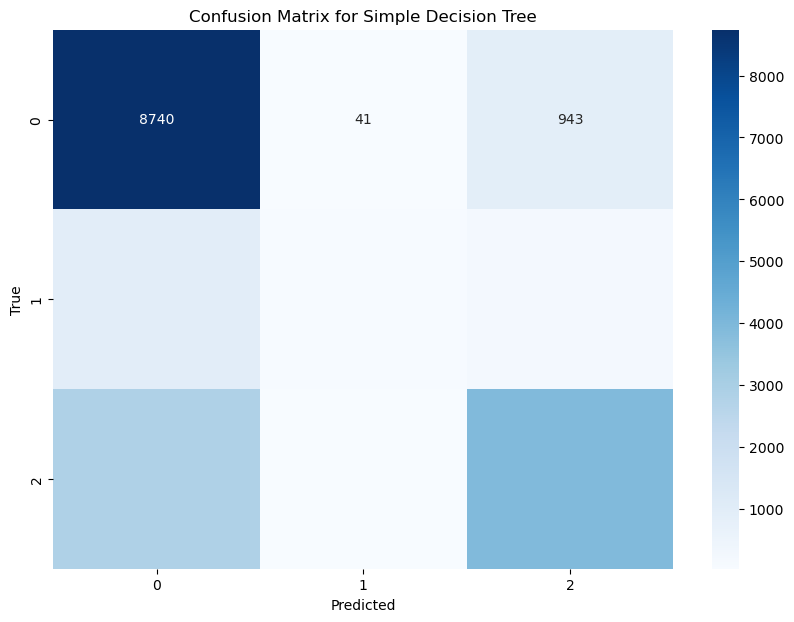

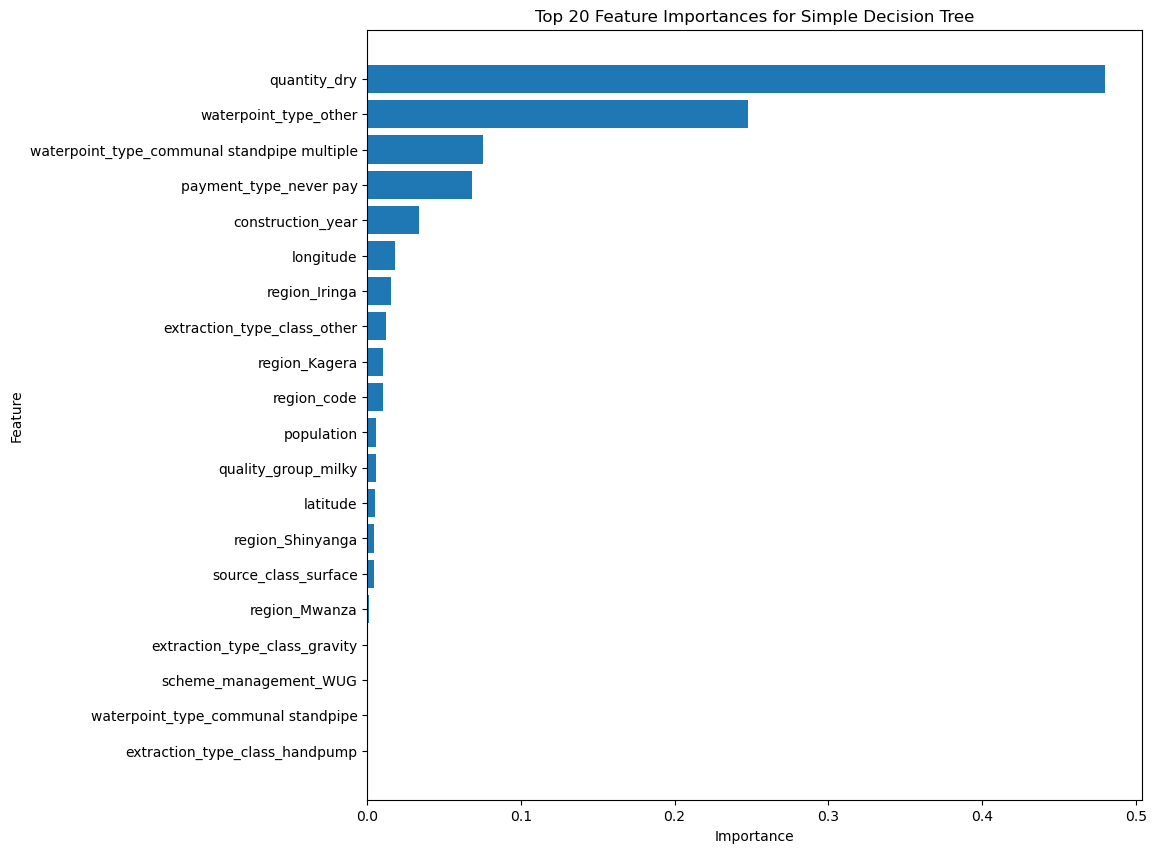

Evaluation for Tuned Decision Tree:
Accuracy: 0.7285072951739618
Confusion Matrix:
[[8771   59  894]
 [ 975  108  210]
 [2676   24 4103]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      9724
           1       0.57      0.08      0.15      1293
           2       0.79      0.60      0.68      6803

    accuracy                           0.73     17820
   macro avg       0.69      0.53      0.54     17820
weighted avg       0.73      0.73      0.70     17820





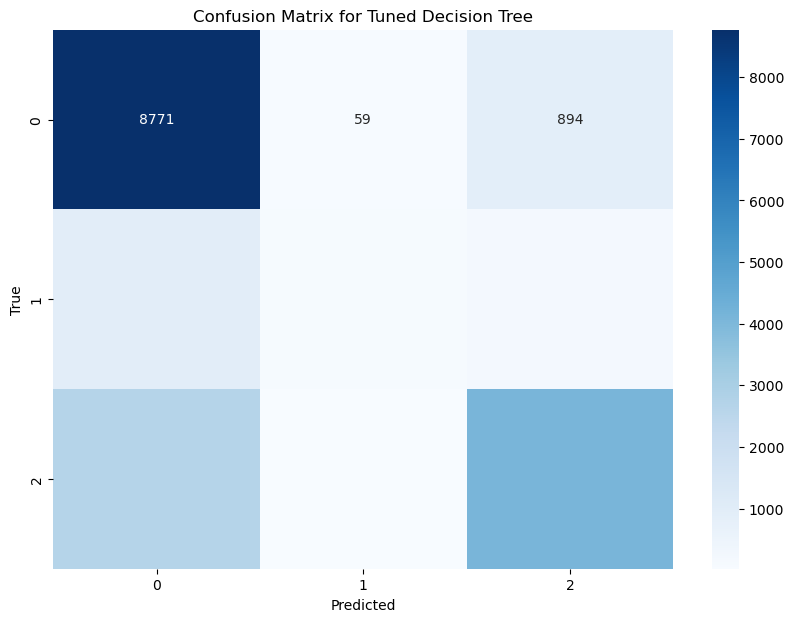

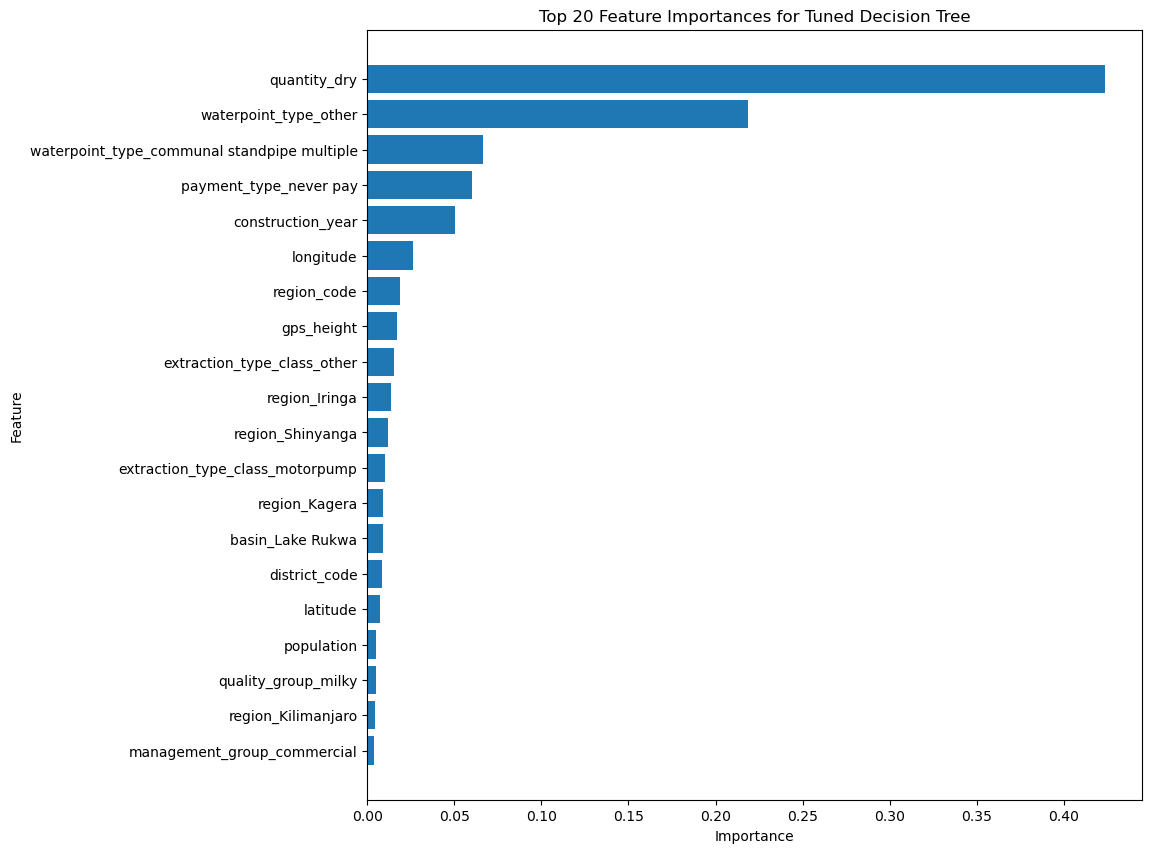

Evaluation for KNN:
Accuracy: 0.7708193041526374
Confusion Matrix:
[[8420  294 1010]
 [ 733  360  200]
 [1694  153 4956]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      9724
           1       0.45      0.28      0.34      1293
           2       0.80      0.73      0.76      6803

    accuracy                           0.77     17820
   macro avg       0.68      0.62      0.64     17820
weighted avg       0.76      0.77      0.76     17820





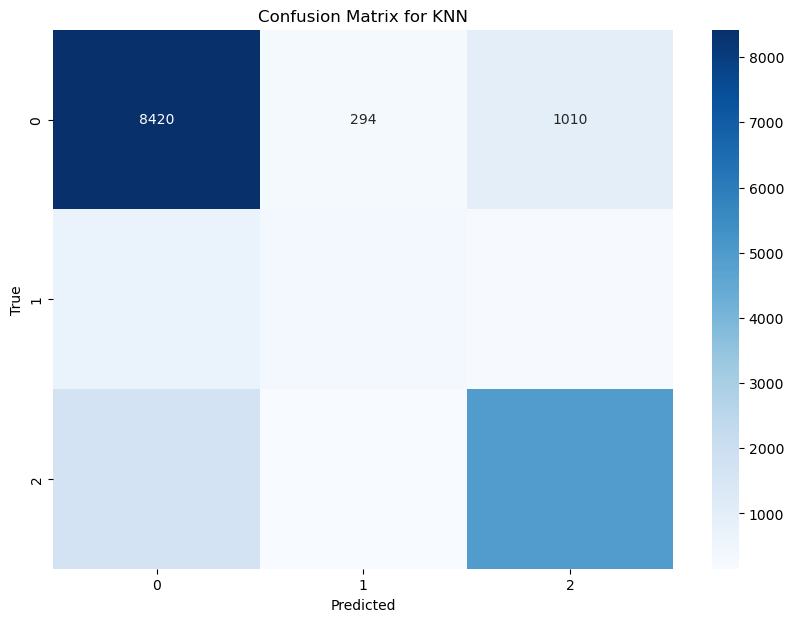

Evaluation for Random Forest:
Accuracy: 0.7534792368125701
Confusion Matrix:
[[9236   27  461]
 [1046   84  163]
 [2677   19 4107]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81      9724
           1       0.65      0.06      0.12      1293
           2       0.87      0.60      0.71      6803

    accuracy                           0.75     17820
   macro avg       0.74      0.54      0.55     17820
weighted avg       0.77      0.75      0.72     17820





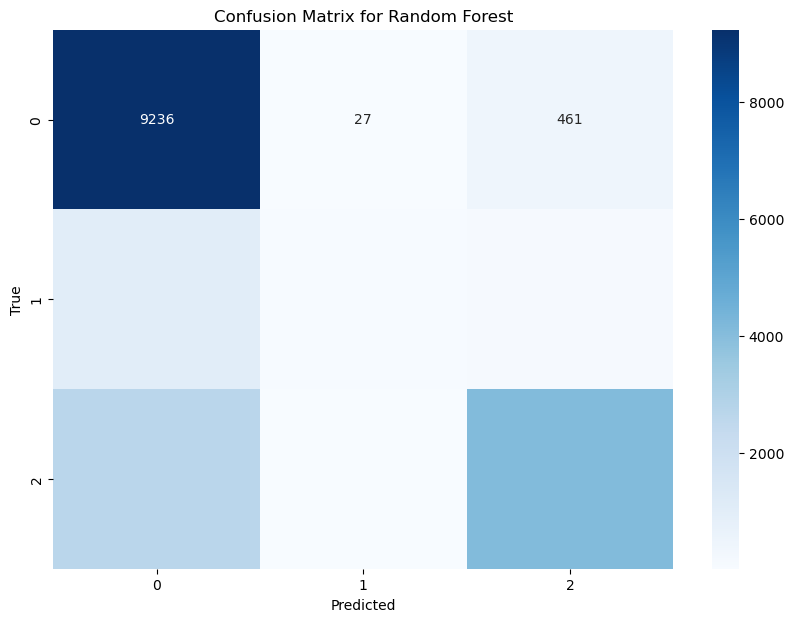

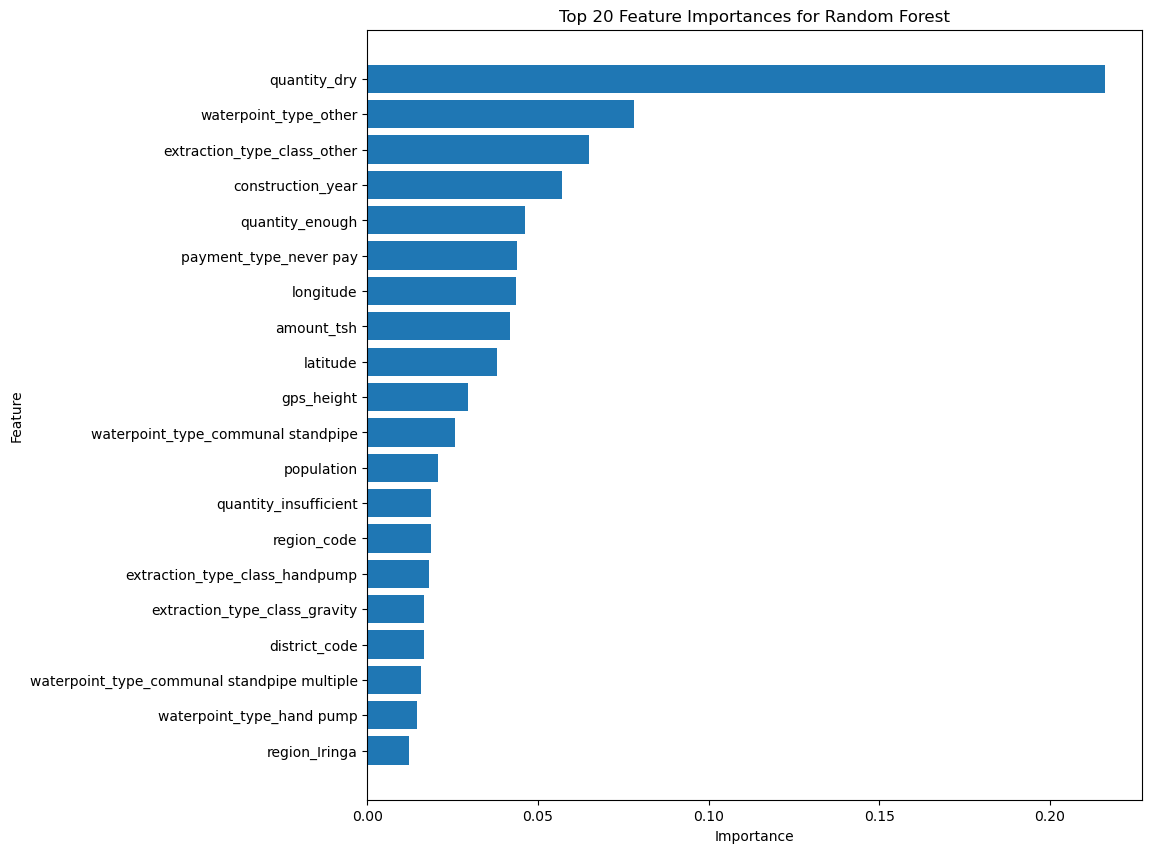

Evaluation for XGBoost:
Accuracy: 0.7924242424242425
Confusion Matrix:
[[8821  141  762]
 [ 777  305  211]
 [1749   59 4995]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      9724
           1       0.60      0.24      0.34      1293
           2       0.84      0.73      0.78      6803

    accuracy                           0.79     17820
   macro avg       0.74      0.63      0.65     17820
weighted avg       0.79      0.79      0.78     17820





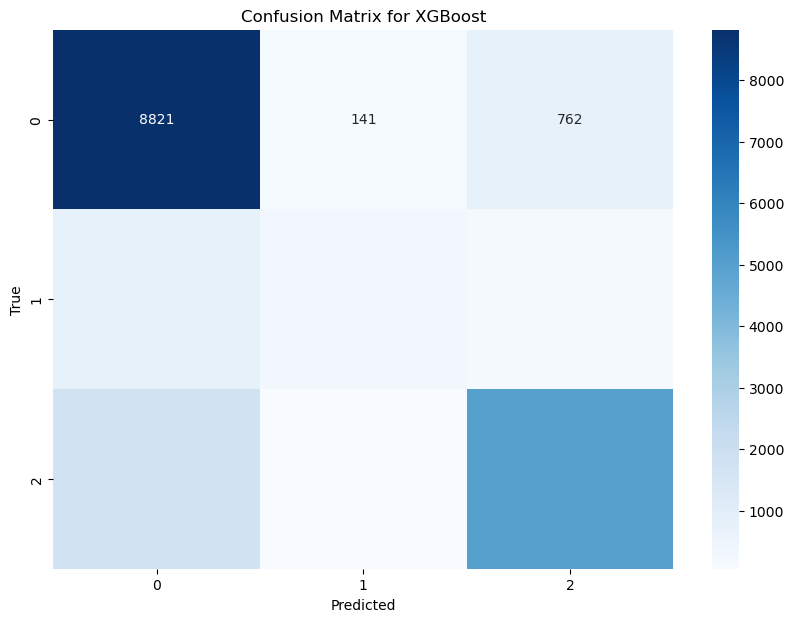

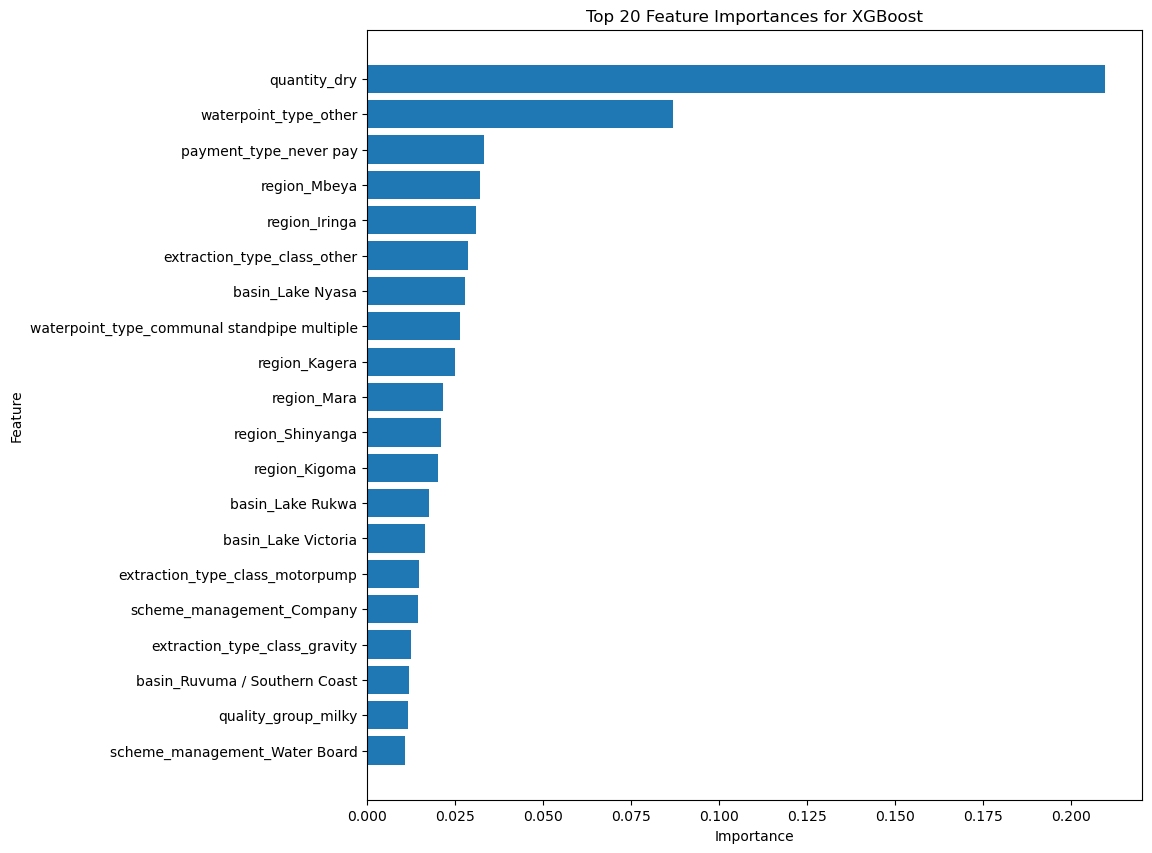

Evaluation for Voting Classifier:
Accuracy: 0.7953423120089786
Confusion Matrix:
[[8936  114  674]
 [ 819  270  204]
 [1792   44 4967]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9724
           1       0.63      0.21      0.31      1293
           2       0.85      0.73      0.79      6803

    accuracy                           0.80     17820
   macro avg       0.75      0.62      0.65     17820
weighted avg       0.79      0.80      0.78     17820





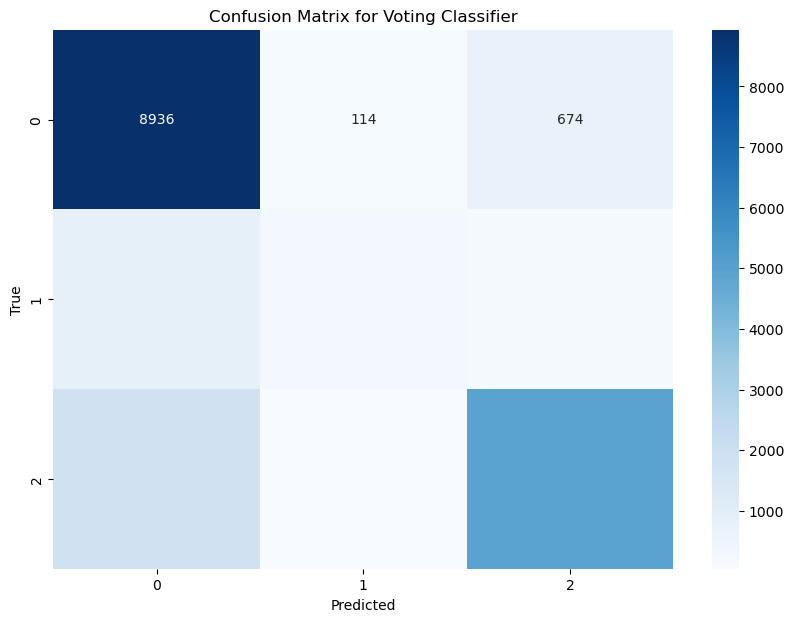

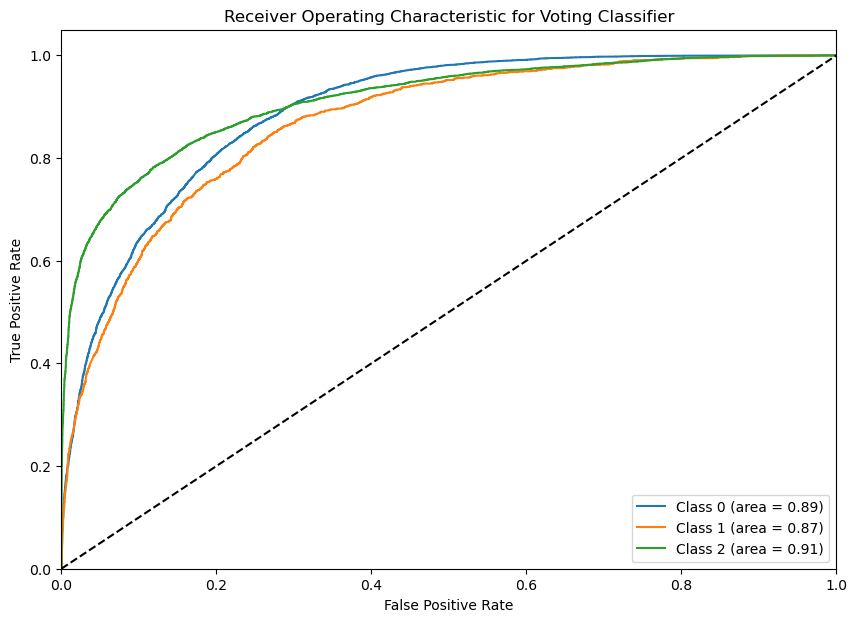

In [15]:
evaluator = Evaluation(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv', use_smote=False)

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = evaluator.train_models()

# Evaluate the models
evaluator.evaluate_models()


Evaluation with SMOTE

Evaluation for Simple Decision Tree:
Accuracy: 0.4802469135802469
Confusion Matrix:
[[4768 4727  229]
 [ 306  950   37]
 [1978 1985 2840]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.49      0.57      9724
           1       0.12      0.73      0.21      1293
           2       0.91      0.42      0.57      6803

    accuracy                           0.48     17820
   macro avg       0.57      0.55      0.45     17820
weighted avg       0.73      0.48      0.54     17820





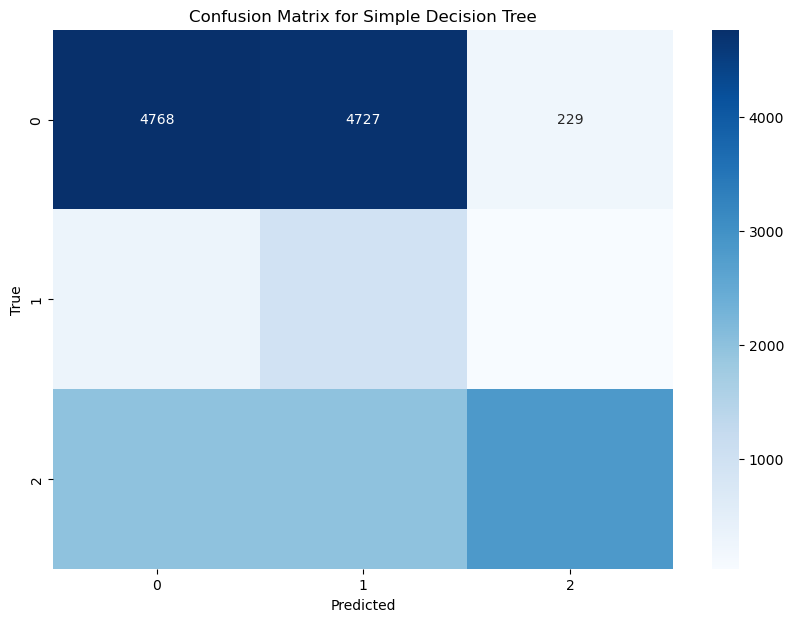

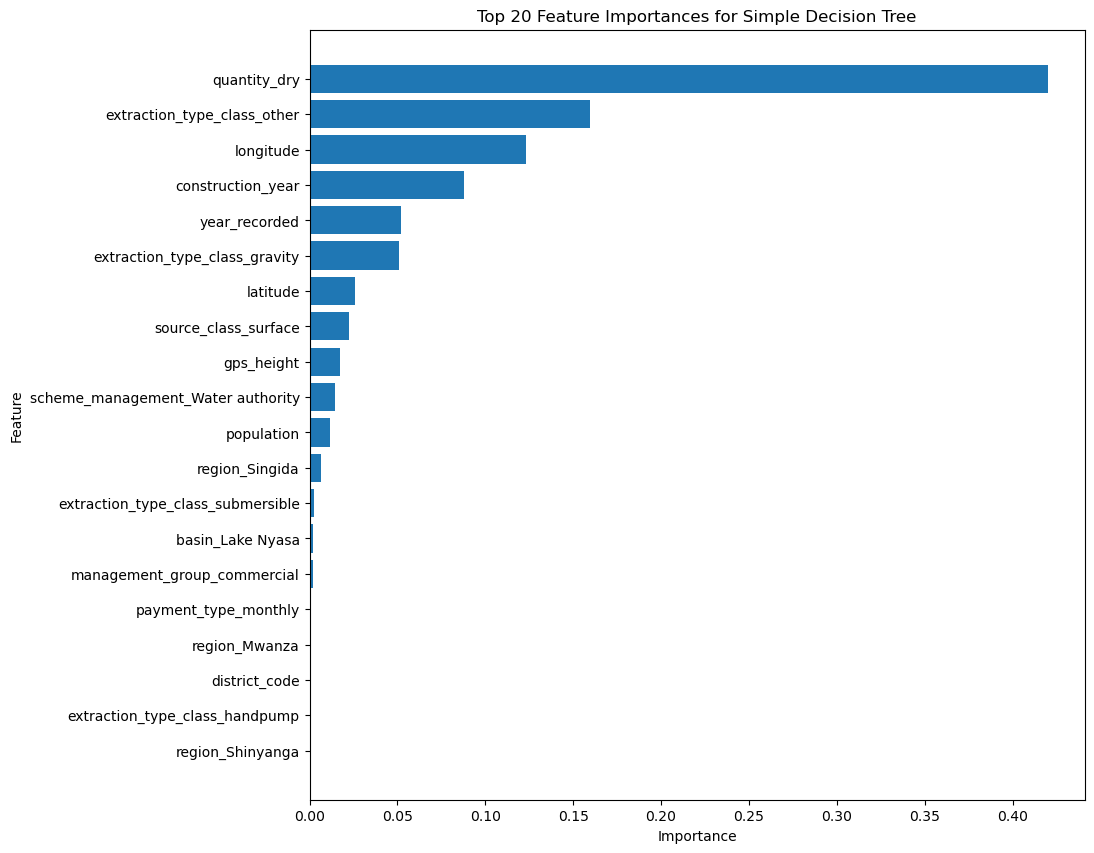

Evaluation for Tuned Decision Tree:
Accuracy: 0.5947250280583614
Confusion Matrix:
[[6650 2751  323]
 [ 436  811   46]
 [2492 1174 3137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      9724
           1       0.17      0.63      0.27      1293
           2       0.89      0.46      0.61      6803

    accuracy                           0.59     17820
   macro avg       0.59      0.59      0.52     17820
weighted avg       0.73      0.59      0.63     17820





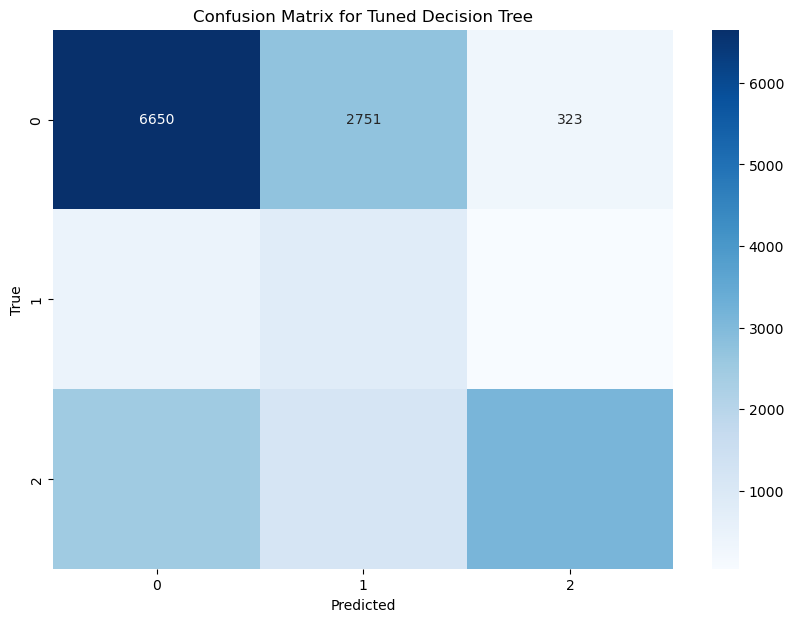

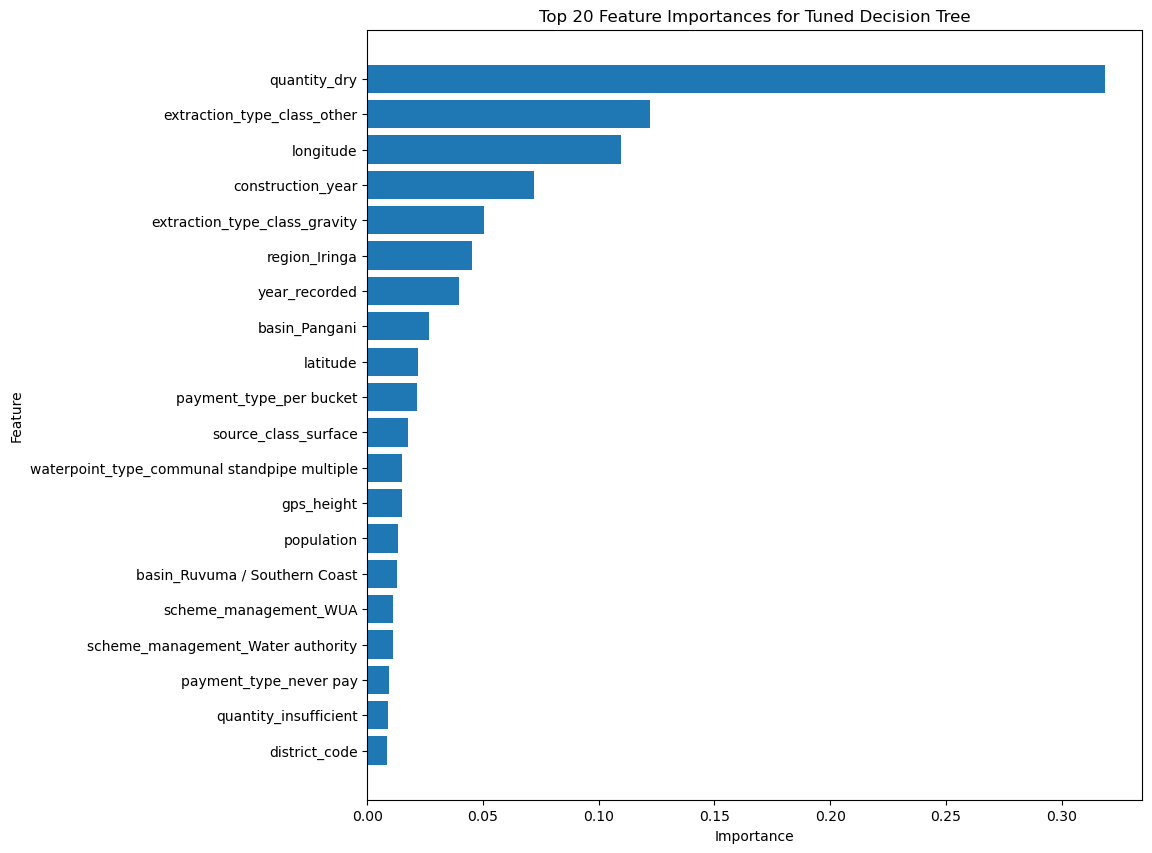

Evaluation for KNN:
Accuracy: 0.7231762065095398
Confusion Matrix:
[[7156 1308 1260]
 [ 421  718  154]
 [1198  592 5013]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.77      9724
           1       0.27      0.56      0.37      1293
           2       0.78      0.74      0.76      6803

    accuracy                           0.72     17820
   macro avg       0.62      0.68      0.63     17820
weighted avg       0.76      0.72      0.74     17820





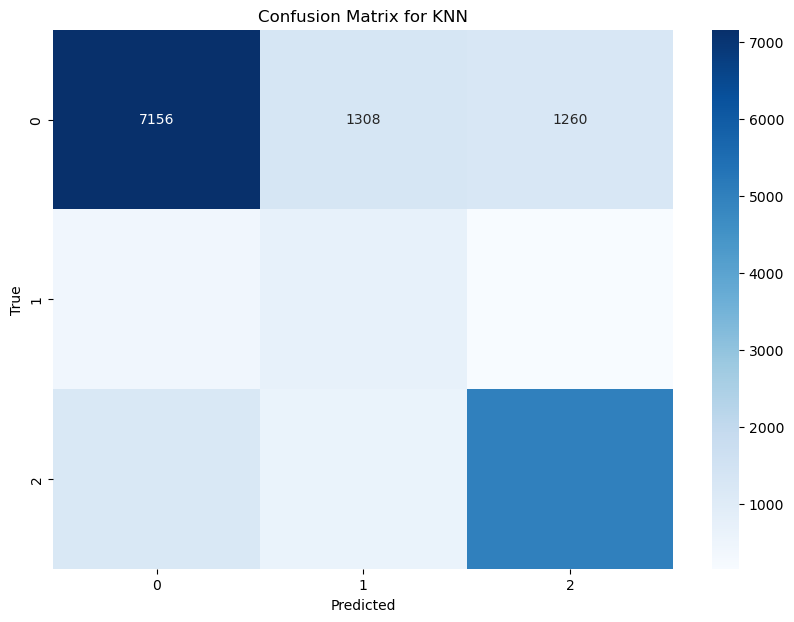

Evaluation for Random Forest:
Accuracy: 0.6842312008978676
Confusion Matrix:
[[6964 2061  699]
 [ 298  879  116]
 [1550  903 4350]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      9724
           1       0.23      0.68      0.34      1293
           2       0.84      0.64      0.73      6803

    accuracy                           0.68     17820
   macro avg       0.62      0.68      0.61     17820
weighted avg       0.77      0.68      0.71     17820





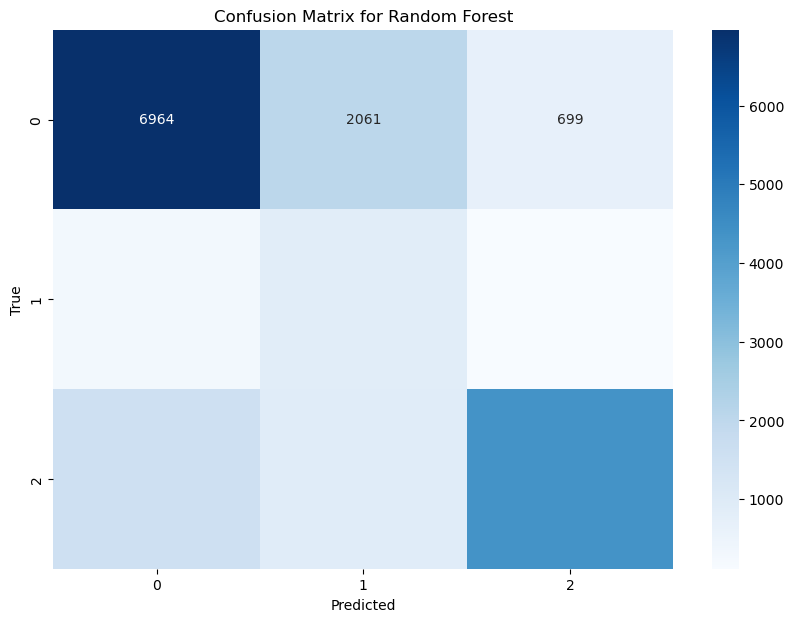

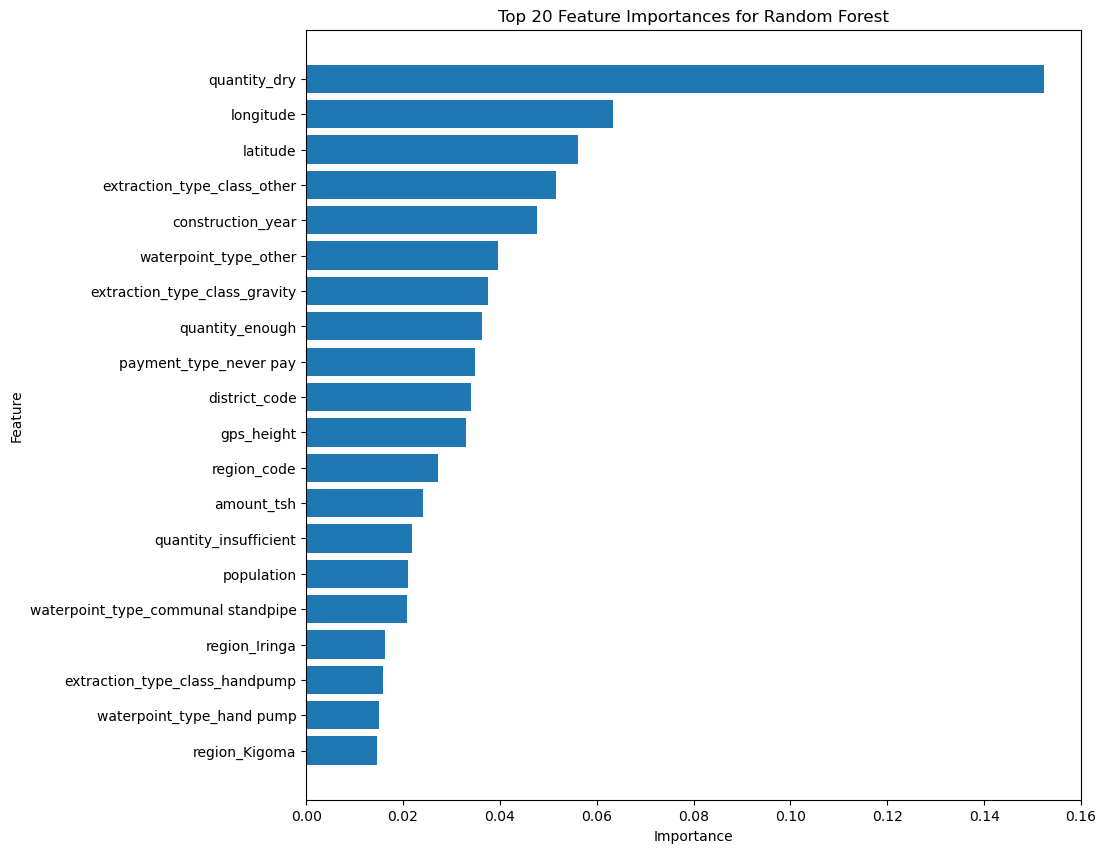

Evaluation for XGBoost:
Accuracy: 0.7374859708193041
Confusion Matrix:
[[7452 1310  962]
 [ 367  748  178]
 [1418  443 4942]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      9724
           1       0.30      0.58      0.39      1293
           2       0.81      0.73      0.77      6803

    accuracy                           0.74     17820
   macro avg       0.64      0.69      0.65     17820
weighted avg       0.77      0.74      0.75     17820





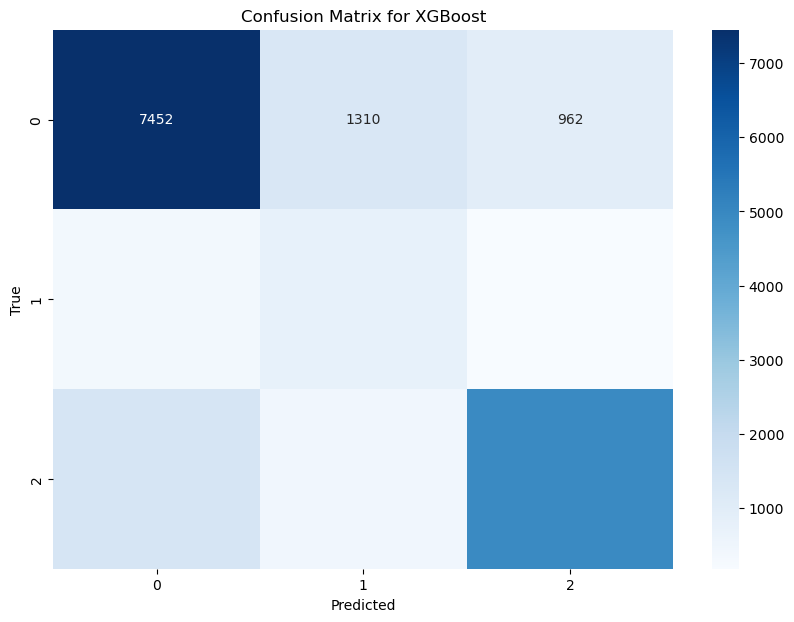

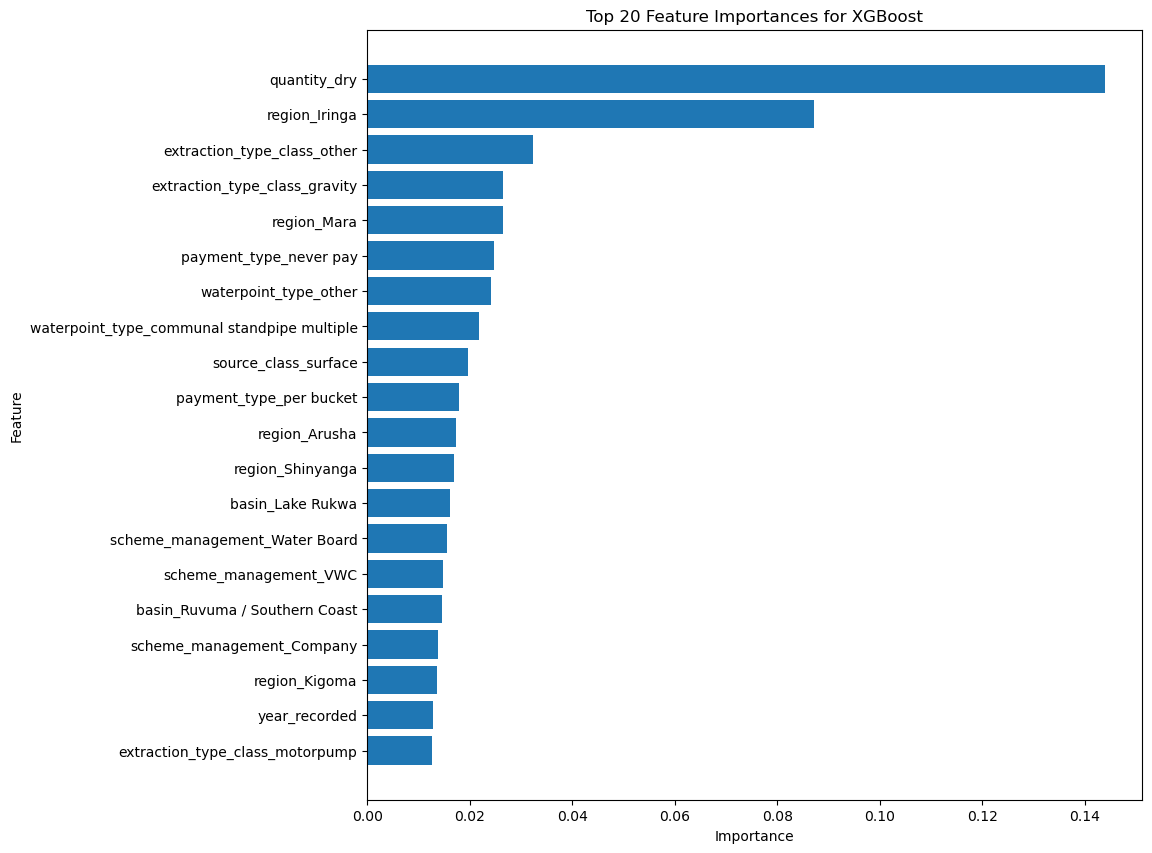

Evaluation for Voting Classifier:
Accuracy: 0.7500561167227834
Confusion Matrix:
[[7495 1271  958]
 [ 369  781  143]
 [1249  464 5090]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      9724
           1       0.31      0.60      0.41      1293
           2       0.82      0.75      0.78      6803

    accuracy                           0.75     17820
   macro avg       0.65      0.71      0.66     17820
weighted avg       0.79      0.75      0.76     17820





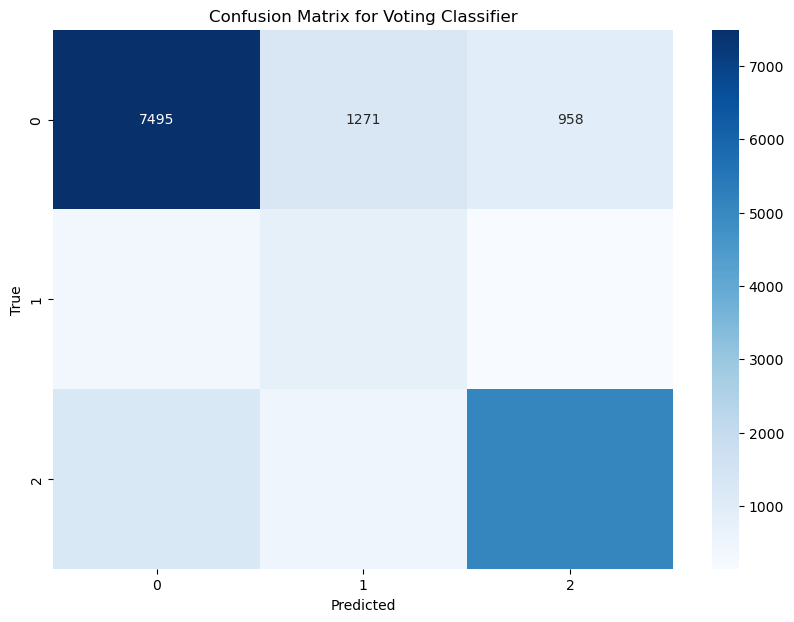

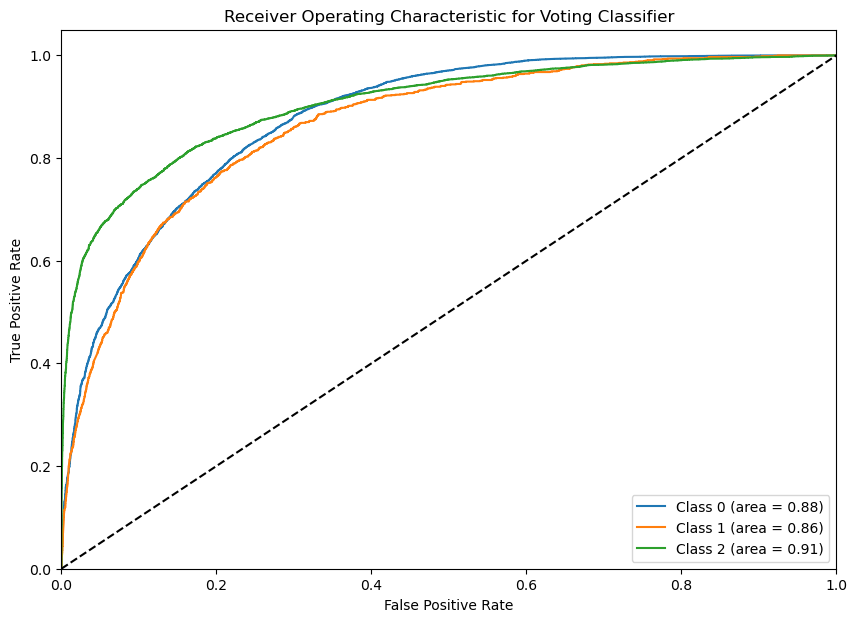

In [16]:
evaluator = Evaluation(train_path='data/cleaned_training_set.csv', test_path='data/cleaned_test_set.csv', use_smote=True)

# Train the models
trained_models, best_model, preprocessor, le, cat_cols, num_cols, X = evaluator.train_models()

# Evaluate the models
evaluator.evaluate_models()


## __4.4 Observations__


**Iteration 1 (No SMOTE):**

- Overall, XGBoost and Voting Classifier performed the best in this iteration, achieving accuracies of 0.79 and 0.80, respectively. However, all models struggled significantly with class 1, evident in their low recall and F1-score values. This indicates a strong bias towards the majority class. The ROC curve for the Voting Classifier, while having a decent AUC of 0.80, also shows that the model might not be distinguishing class 1 well.

**Iteration 2 (with SMOTE):**

- The introduction of SMOTE significantly improved the model's ability to predict class 1. This is evident in the increased recall and F1-scores for class 1 across all models. However, it came at the cost of overall accuracy for some models, most notably the Simple Decision Tree. The improvement is especially pronounced in KNN and XGBoost, which now show balanced performance across all classes. The Voting Classifier still leads with a 0.75 accuracy, but its ROC curve might indicate further improvement potential.

## Model Comparison Between Iterations

| Model               | Iteration 1 (No SMOTE) | Iteration 2 (SMOTE) | Key Change                             |
| -------------------- | ---------------------- | --------------------- | -------------------------------------- |
| Simple Decision Tree | 0.72                   | 0.48                 | Significant decrease in overall accuracy |
| Tuned Decision Tree   | 0.73                   | 0.59                 | Decrease in overall accuracy           |
| KNN                  | 0.77                   | 0.72                 | Slight decrease, better class balance   |
| Random Forest        | 0.75                   | 0.68                 | Decrease, better class balance         |
| XGBoost              | 0.79                   | 0.74                 | Slight decrease, better class balance   |
| Voting Classifier    | 0.80                   | 0.75                 | Decrease, better class balance         |

- SMOTE generally improved the recall and F1-score for class 1 significantly.
- This improvement often came at a cost to overall accuracy, especially for simpler models like the Simple Decision Tree.
- KNN and XGBoost showed the most balanced improvements, maintaining decent accuracy while handling class imbalance better.

## Performance Comparison Table

| Model               | Accuracy (No SMOTE) | Accuracy (SMOTE) | Recall (Class 1, No SMOTE) | Recall (Class 1, SMOTE) |
| -------------------- | ---------------------- | --------------------- | ----------------------------- | --------------------------- |
| Simple Decision Tree | 0.72                   | 0.48                 | 0.07                       | 0.73                         |
| Tuned Decision Tree   | 0.73                   | 0.59                 | 0.08                       | 0.63                         |
| KNN                  | 0.77                   | 0.72                 | 0.28                       | 0.56                         |
| Random Forest        | 0.75                   | 0.68                 | 0.06                       | 0.68                         |
| XGBoost              | 0.79                   | 0.74                 | 0.24                       | 0.58                         |
| Voting Classifier    | 0.80                   | 0.75                 | 0.21                       | 0.60                         |




**Visualizing Disparities in Performance**

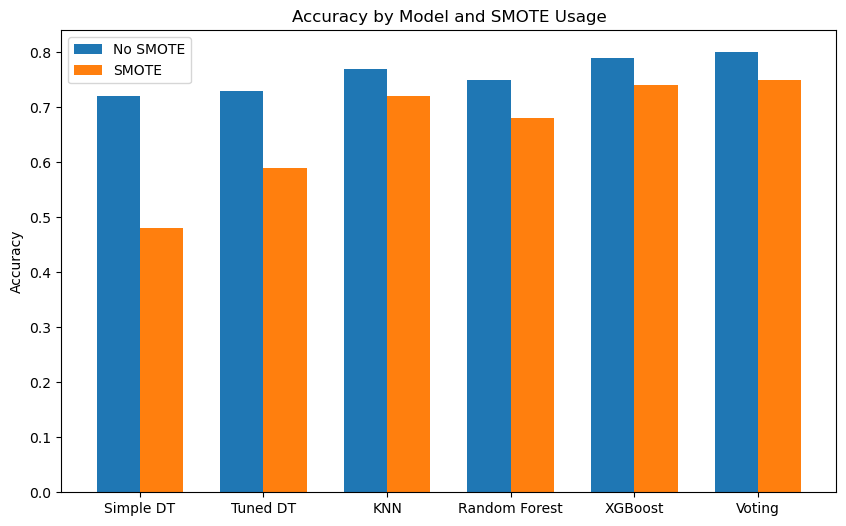

In [17]:

# Data for plotting
models = ['Simple DT', 'Tuned DT', 'KNN', 'Random Forest', 'XGBoost', 'Voting']
accuracy_no_smote = [0.72, 0.73, 0.77, 0.75, 0.79, 0.80]
accuracy_smote = [0.48, 0.59, 0.72, 0.68, 0.74, 0.75]

width = 0.35
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracy_no_smote, width, label='No SMOTE')
rects2 = ax.bar(x + width/2, accuracy_smote, width, label='SMOTE')

# Add text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model and SMOTE Usage')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()